In [1]:
# import necessary libraries 
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web

def MovingAverageCrossStrategy(
    stock_symbol = 'TSLA', 
    start_date = '2020-01-01', 
    end_date = '2020-12-01', 
    short_window = 20, 
    long_window = 50, 
    moving_avg = 'SMA', 
    display_table = True
    ):
    
    '''
    The function takes the stock symbol, time-duration of analysis, 
    look-back periods and the moving-average type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # stock_symbol - (str)stock ticker as on Yahoo finance. Eg: 'ULTRACEMCO.NS' 
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = web.DataReader(stock_symbol, 'yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 
                        
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    # Create a short & long simple moving average column  
    if moving_avg == 'SMA':
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    # Create short & long exponential moving average column
    elif moving_avg == 'EMA':
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
        # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where(stock_df[short_window_col] > stock_df[long_window_col], 1.0, 0.0) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (13,6), dpi = 75)
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
    stock_df[short_window_col].plot(color = 'b', lw = 1, label = short_window_col)
    stock_df[long_window_col].plot(color = 'g', lw = 1, label = long_window_col) 

    # plot 'buy' signals
    plt.plot(
        stock_df[stock_df['Position'] == 1].index, 
        stock_df[short_window_col][stock_df['Position'] == 1], 
        '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy'
        )
    # plot 'sell' signals
    plt.plot(
        stock_df[stock_df['Position'] == -1].index, 
        stock_df[short_window_col][stock_df['Position'] == -1], 
        'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell'
        )
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show();
    
    if display_table == True:
        df_pos = stock_df[(stock_df['Position'] == 1) | (stock_df['Position'] == -1)]
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

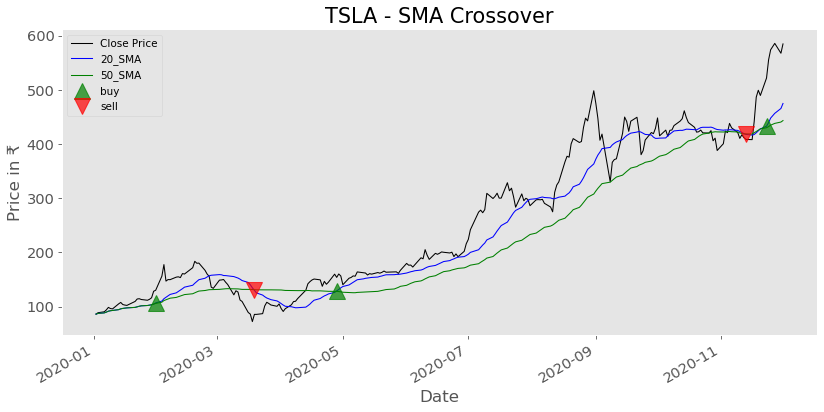

+---------------------+---------------+----------+----------+----------+------------+
| Date                |   Close Price |   20_SMA |   50_SMA |   Signal | Position   |
|---------------------+---------------+----------+----------+----------+------------|
| 2020-01-31 00:00:00 |       130.114 |  106.716 |  105.732 |        1 | Buy        |
| 2020-03-19 00:00:00 |        85.528 |  129.86  |  131.14  |        0 | Sell       |
| 2020-04-28 00:00:00 |       153.824 |  128.772 |  127.957 |        1 | Buy        |
| 2020-11-13 00:00:00 |       408.5   |  417.706 |  418.701 |        0 | Sell       |
| 2020-11-23 00:00:00 |       521.85  |  432.954 |  430.072 |        1 | Buy        |
+---------------------+---------------+----------+----------+----------+------------+


In [2]:
MovingAverageCrossStrategy()

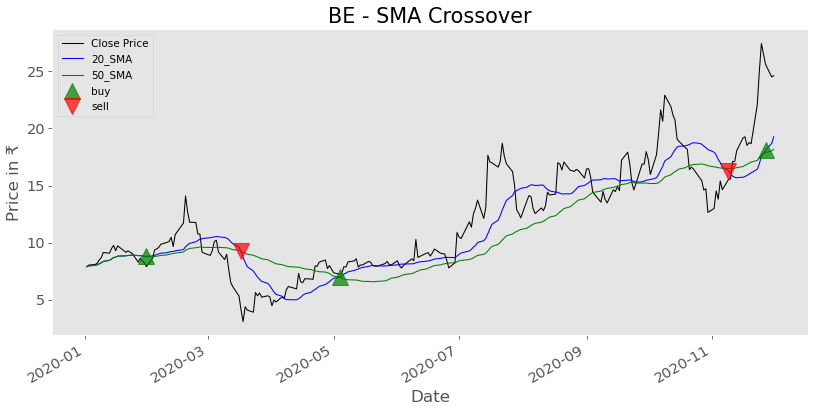

+---------------------+---------------+----------+----------+----------+------------+
| Date                |   Close Price |   20_SMA |   50_SMA |   Signal | Position   |
|---------------------+---------------+----------+----------+----------+------------|
| 2020-01-31 00:00:00 |          7.88 |   8.7935 |   8.75   |        1 | Buy        |
| 2020-03-17 00:00:00 |          4.08 |   9.2415 |   9.243  |        0 | Sell       |
| 2020-05-04 00:00:00 |          7.21 |   6.9775 |   6.9542 |        1 | Buy        |
| 2020-11-09 00:00:00 |         15.53 |  16.285  |  16.4924 |        0 | Sell       |
| 2020-11-27 00:00:00 |         25.63 |  18.094  |  17.8886 |        1 | Buy        |
+---------------------+---------------+----------+----------+----------+------------+


In [3]:
MovingAverageCrossStrategy('BE')